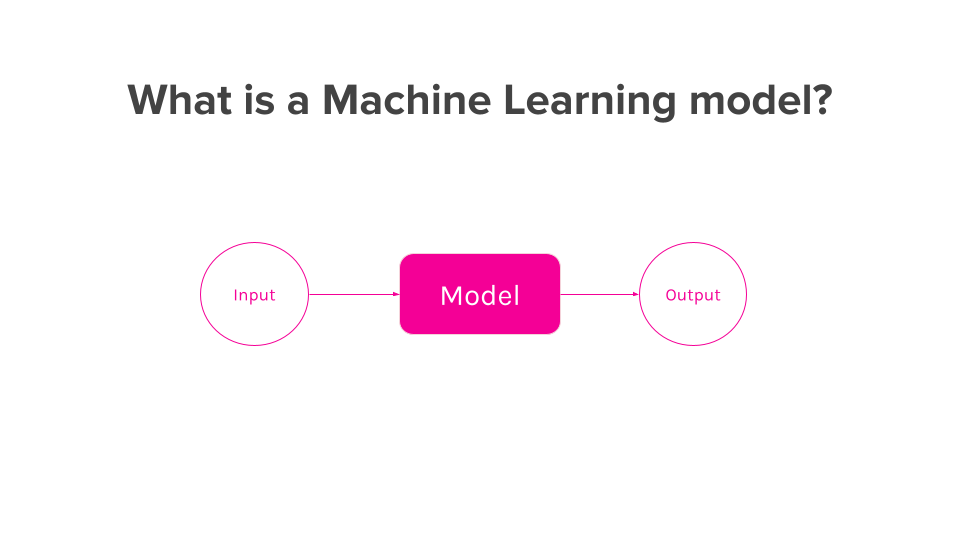

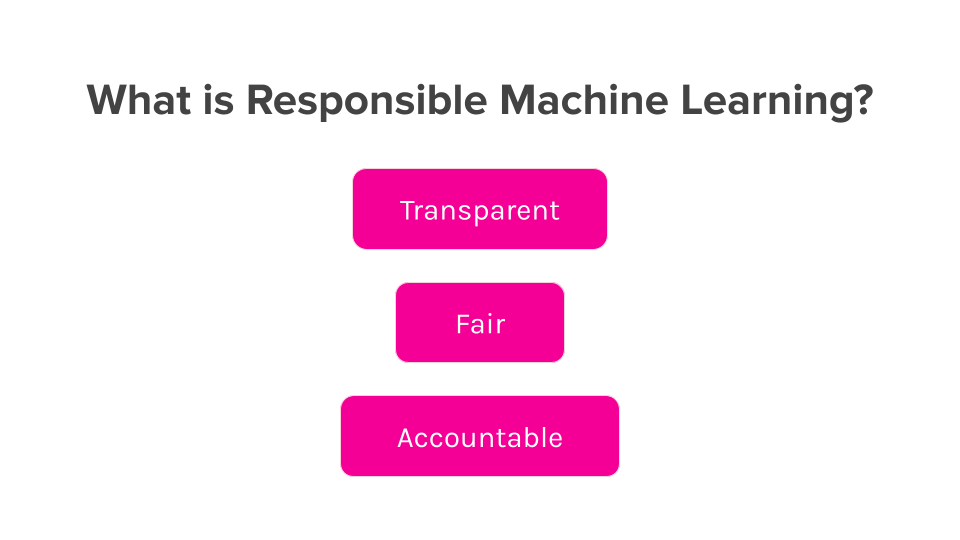

### Preparations

In [ ]:
# Installations
!pip install fairlearn
!pip install aif360
!pip install BlackBoxAuditing

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import plotly.express as px

### Load data and specify input, output and protected attribue

In [ ]:
# Loading the data
data = pd.read_csv('adult_preprocessed.csv', index_col = 0)

In [ ]:
# Inspect data
data.head()

,age,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,sex,salary
0,-0.995129,-1.197259,-0.034087,-0.173795,-0.261940,-0.246558,-0.01431,0.663711,-0.189609,-0.293019,-0.205606,-0.02074,1.0,<=50K
1,-0.046942,-0.419335,0.772930,-0.173795,-0.261940,-0.246558,-0.01431,0.663711,-0.189609,-0.293019,-0.205606,-0.02074,1.0,<=50K
2,-0.776316,0.747550,-0.034087,-0.173795,3.817672,-0.246558,-0.01431,-1.506680,-0.189609,-0.293019,-0.205606,-0.02074,1.0,>50K
3,0.390683,-0.030373,-0.034087,-0.173795,-0.261940,-0.246558,-0.01431,0.663711,-0.189609,-0.293019,-0.205606,-0.02074,1.0,>50K
4,-1.505691,-0.030373,-0.841104,-0.173795,-0.261940,4.055836,-0.01431,-1.506680,-0.189609,-0.293019,-0.205606,-0.02074,0.0,<=50K


In [ ]:
# Check the distribution between protected attribute and the label
pd.crosstab(data['sex'], data['salary'])

salary,<=50K,>50K
sex,,
0.0,14423,1769
1.0,22732,9918


In [ ]:
# Get input (X), output (y) and protected/sensitive attribute
X = data[data.columns[:-2]]
y = [1 if x == '>50K' else 0 for x in data['salary']]
protected = data['sex']

### Build Machine Learning models

**Caution!** In this notebook we are going to build the models on all data, not split the data into train and test set. This is only done due to time constraints in the workshop. It is not good Machine Learning practice. 

In [ ]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [ ]:
# Function for training models
def train_models(X, y):
  log_reg = LogisticRegression(random_state = 1).fit(X = X, y = y)
  neural_network = MLPClassifier(random_state = 1).fit(X = X, y = y)

  return log_reg, neural_network

In [ ]:
# Train models
log_reg, neural_network = train_models(X, y)

### Evaluate the models by standard metrics

In [ ]:
# Function for printing the accuracy and getting the predictions
def evaluate_models(lr_model, nn_model, X, y):
  
  # Logistic regression model
  pred_lr = lr_model.predict(X)
  accuracy_lr = sum(pred_lr == y) / len(y)
  print('Accuracy Logistic Regression: ', round(accuracy_lr, 2))

  # Neural network model
  pred_nn = nn_model.predict(X)
  accuracy_nn = sum(pred_nn == y) / len(y)
  print('Accuracy Neural Network: ', round(accuracy_nn, 2))

  return pred_lr, pred_nn

In [ ]:
# Get accuracy of the models we just built
pred_lr, pred_nn = evaluate_models(log_reg, neural_network, X, y)

Accuracy Logistic Regression:  0.79
Accuracy Neural Network:  0.8


### Interpret the models

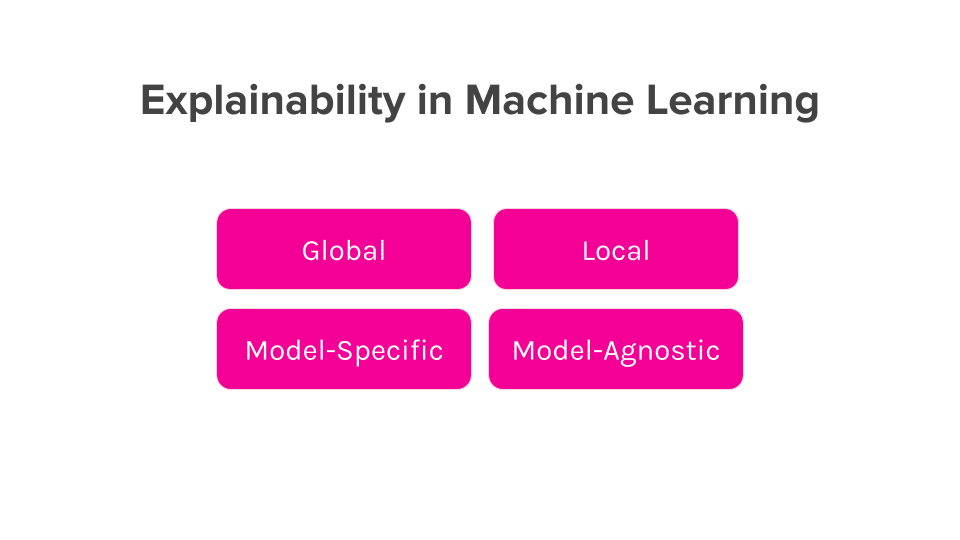

In [ ]:
# Logistic regression
px.bar(x = X.columns, y = log_reg.coef_[0])

In [ ]:
# Neural network model - really hard because it's so many coefficients!
print(neural_network.coefs_[0].shape)
print(neural_network.coefs_[1].shape)

(12, 100)
(100, 1)


### Fairness evaluation

#### Comparing model metrics between the privileged and unprivileged group

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

In [ ]:
# Function for comparing metrics
def compare_metrics(y, pred):
  metrics_results = MetricFrame(metrics = metrics, 
                                y_true = y, 
                                y_pred = pred, 
                                sensitive_features = protected)
  
  print(metrics_results.by_group)
  
  #results_long = pd.melt(metrics_results.by_group.reset_index(), id_vars = 'sex', value_vars = metrics.keys(), var_name = 'metric', value_name = 'result')
  
  #results_long['sex'] = ['Male' if x == 1 else 'Female' for x in results_long['sex']]

  #px.bar(results_long, x = 'metric', y = 'result', color = 'sex', barmode = 'group').show()

In [ ]:
# Define what metrics to look at
metrics = {'accuracy' : accuracy_score}

In [ ]:
# Logistic regression
compare_metrics(y, pred_lr)

     accuracy
sex          
0.0  0.871789
1.0  0.754211


In [ ]:
# Neural network
compare_metrics(y, pred_nn)

     accuracy
sex          
0.0  0.871727
1.0  0.770413


#### Comparing model outcome between the privileged and unprivileged group

In [ ]:
# Function for checking the proportion of high-salary classifications
def check_outcome_proportions(pred):
  prop_women = sum(pred[protected == 0])/ len(pred[protected == 0])
  print('Share of women classified with high salary :', round(prop_women, 2))

  prop_men = sum(pred[protected == 1])/ len(pred[protected == 1])
  print('Share of men classified with high salary :', round(prop_men, 2))

In [ ]:
# Logistic regression
check_outcome_proportions(pred_lr)

Share of women classified with high salary : 0.07
Share of men classified with high salary : 0.15


In [ ]:
# Logistic regression
check_outcome_proportions(pred_nn)

Share of women classified with high salary : 0.09
Share of men classified with high salary : 0.18


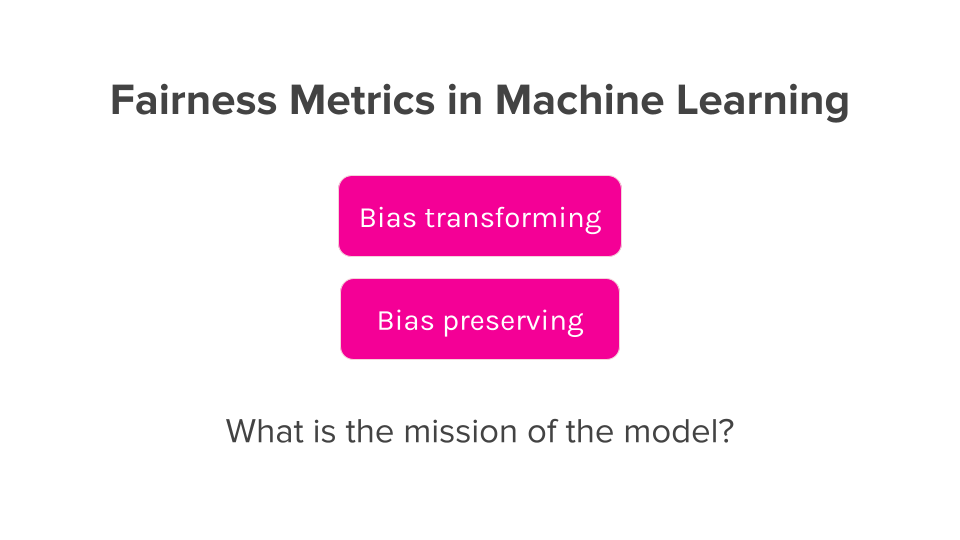

In [ ]:
# Demographic parity
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio

In [ ]:
# Function for calculating fairness metrics
def calculate_fairness(y, pred):
  dpr = demographic_parity_ratio(y_true=y, y_pred=pred, sensitive_features=protected)
  print('Demographic Parity Ratio: ', round(dpr, 2))

  eor = equalized_odds_ratio(y_true=y, y_pred=pred, sensitive_features=protected)
  print('Equalized Odds Ratio: ', round(eor, 2))

In [ ]:
# Logistic regression
calculate_fairness(y, pred_lr)

Demographic Parity Ratio:  0.49
Equalized Odds Ratio:  0.73


In [ ]:
# Neural network
calculate_fairness(y, pred_nn)

Demographic Parity Ratio:  0.5
Equalized Odds Ratio:  0.78


### Bias mitigation

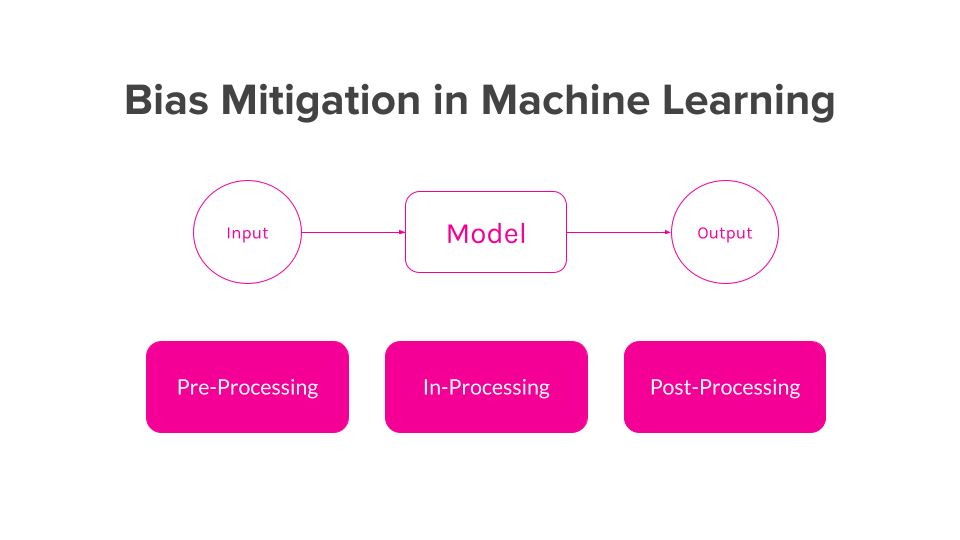

#### Transform data

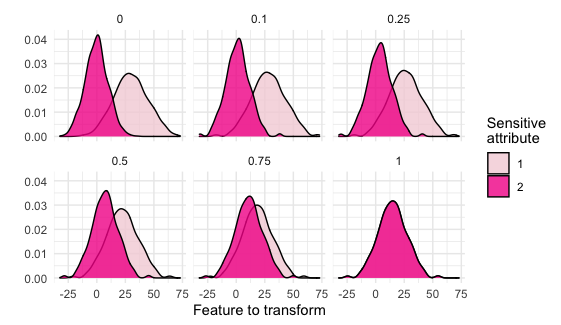

In [ ]:
from aif360.datasets import BinaryLabelDataset

In [ ]:
# Turn data into BinaryLabelDataset object for transformation
data_copy = data.copy()
data_copy['salary'] = y
binary_label_dataset = BinaryLabelDataset(df = data_copy, label_names = ['salary'], protected_attribute_names= ['sex'])

In [ ]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [ ]:
# Create the disparate impact remover
dir = DisparateImpactRemover(repair_level=0.75, sensitive_attribute='sex')

In [ ]:
# Transform the data
transformed_data = dir.fit_transform(binary_label_dataset)

In [ ]:
# Turn into a pandas dataframe again
new_data = transformed_data.convert_to_dataframe()[0]

#### Train models again

In [ ]:
# Pick columns for the modelling
X_new = new_data[new_data.columns[:-2]]

In [ ]:
# Train new models on the transformed data
log_reg_new, neural_network_new = train_models(X_new, y)

#### Evaluation

In [ ]:
# Evaluate models
pred_lr_new, pred_nn_new = evaluate_models(log_reg_new, neural_network_new, X_new, y)

Accuracy Logistic Regression:  0.79
Accuracy Neural Network:  0.81


In [ ]:
# Function for getting a full fairness evaluation
def fairness_evaluation(y, pred):
  print('Metrics comparison across groups')
  compare_metrics(y, pred)

  print('\n Check outcome proportions')
  check_outcome_proportions(pred)

  print('\n Calculate fairness metrics')
  calculate_fairness(y, pred)

In [ ]:
# Logistic regression on new data
fairness_evaluation(y, pred_lr_new)

Metrics comparison across groups
     accuracy
sex          
0.0  0.868886
1.0  0.752374

 Check outcome proportions
Share of women classified with high salary : 0.08
Share of men classified with high salary : 0.14

 Calculate fairness metrics
Demographic Parity Ratio:  0.61
Equalized Odds Ratio:  0.89


In [ ]:
# Neural network on new data
fairness_evaluation(y, pred_nn_new)

Metrics comparison across groups
     accuracy
sex          
0.0  0.875988
1.0  0.771302

 Check outcome proportions
Share of women classified with high salary : 0.08
Share of men classified with high salary : 0.18

 Calculate fairness metrics
Demographic Parity Ratio:  0.45
Equalized Odds Ratio:  0.73


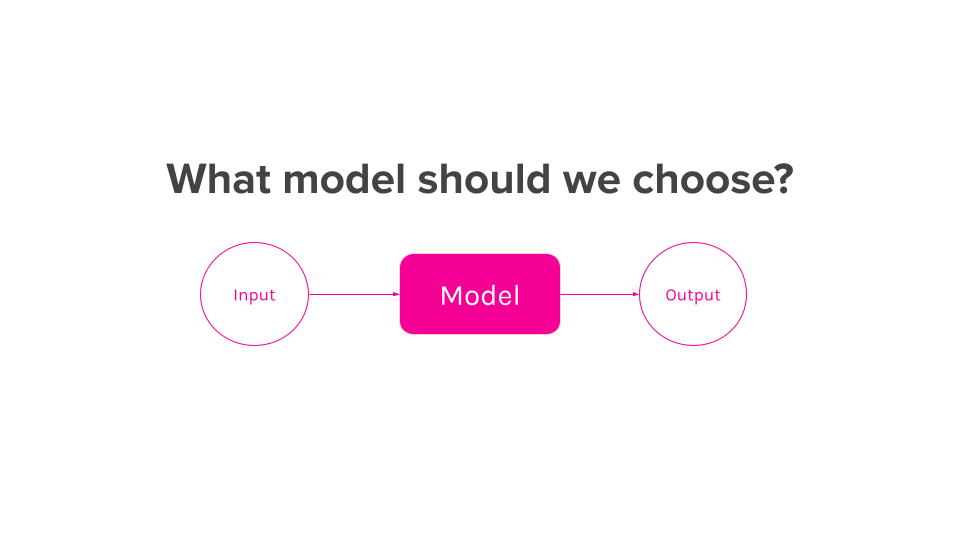